# Artificial Art Generation 
   -Vaibhav Haswani

### Importting essentials and Loading Data

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

download dataset from [here](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

In [3]:
data_dir='datasets/artworks/'   #dataset directory

In [4]:
os.listdir(data_dir+'resized')[:10]

['Albrecht_Du¦êrer_1.jpg',
 'Albrecht_Du¦êrer_10.jpg',
 'Albrecht_Du¦êrer_100.jpg',
 'Albrecht_Du¦êrer_101.jpg',
 'Albrecht_Du¦êrer_102.jpg',
 'Albrecht_Du¦êrer_103.jpg',
 'Albrecht_Du¦êrer_104.jpg',
 'Albrecht_Du¦êrer_105.jpg',
 'Albrecht_Du¦êrer_106.jpg',
 'Albrecht_Du¦êrer_107.jpg']

### Creating dataloader object with necessary transformations

In [9]:
#declaring transforms and other parameters
img_size=(64,64)                         #required image size
batch_size=128
stats=((0.5,0.5,0.5),(0.5,0.5,0.5))      #normalization stats: mean and std deviation
tfm=tt.Compose([
    tt.Resize(img_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [10]:
train_ds=ImageFolder(data_dir,transform=tfm)  #loading dataset from folder

In [11]:
len(train_ds)

8683

In [12]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,pin_memory=True,num_workers=4) #creating dataloader object with the previous dataset

In [13]:
from torchvision.utils import make_grid
def denorm(img,mean,std):
    '''func to denormalize the image'''
    mean=torch.tensor(mean).reshape(1,3,1,1)
    std=torch.tensor(std).reshape(1,3,1,1)
    return img*std+mean
def show_batch(dl):
    '''function to display training batch'''
    for img,_ in dl:
        img=denorm(img[:64],*stats)
        plt.figure(figsize=(10,10))
        plt.imshow(make_grid(img,nrow=8).permute(1,2,0))
        plt.axis('off')
        break

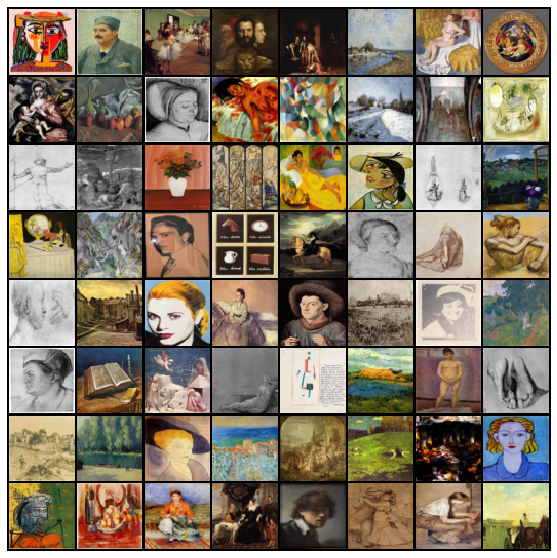

In [14]:
show_batch(train_dl)

**Classes and functions to interface the data and model objects with gpu to utilize it**

In [15]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data,device):
    if isinstance(data ,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device)

class DeviceDataLoader:
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [41]:
train_dl=DeviceDataLoader(train_dl,device)  #interfacing gpu to our dataloader

## Defining Models (Discriminative and Generative)

In [42]:
#discriminator model
discriminator=nn.Sequential(
    #in 64x64x3
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    #out 32x32x64
    
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    #out 16x16x128
    
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    #out 8x8x256
    
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    #out 4x4x512
    
    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    #out 1x1x1
    
    nn.Flatten(),
    nn.Sigmoid()
    
    
)

In [43]:
#generator model
latent_size=128
generator=nn.Sequential(

    #in 1x1xlatent_size
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
    #out 4x4xlatent_size
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    #out 8x8x256
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    # 16x16x128
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    #out 32x32x64
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
    #out 64x64x3
    
)

In [44]:
discriminator=to_device(discriminator,device)
generator=to_device(generator,device)

## Training Models

In [45]:
#training functions 
def train_discrim(real_imgs,opt_d):
    opt_d.zero_grad()
    
    #training discriminator for real images setting target 1 for real
    real_preds=discriminator(real_imgs)
    real_targets=torch.ones(real_imgs.size(0),1,device=device)
    real_loss=F.binary_cross_entropy(real_preds,real_targets)
    real_score=torch.mean(real_preds).mean()
    #training for fake images setting 0 for fake
    latent_vector=torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images=generator(latent_vector)
    fake_preds=discriminator(fake_images)
    fake_targets=torch.zeros(fake_images.size(0),1,device=device)
    fake_loss=F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score=torch.mean(fake_preds).mean()
    #final loss and backprop
    loss=real_loss+fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(),real_score,fake_score


def train_gen(opt_g):
    opt_g.zero_grad()
    #we'll try to present fake images as real to the discriminator
    #random vector
    latent_vector=torch.randn(batch_size,latent_size,1,1,device=device)
    fake_imgs=generator(latent_vector)
    #presenting targets 1 as actual targets
    fake_targets=torch.ones(fake_imgs.size(0),1,device=device)
    fake_preds=discriminator(fake_imgs)
    loss=F.binary_cross_entropy(fake_preds,fake_targets)
    
    #backprop and parameter update
    loss.backward()
    opt_g.step()
    
    return loss.item()
    

In [46]:
# util functions training
#imports
from torchvision.utils import save_image
from tqdm.notebook import tqdm

In [47]:
#utility function to save a grid of images generated by generator
sample_dir = 'generated/artwork'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images.cpu(),*stats), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.cpu().detach(),*stats), nrow=8).permute(1, 2, 0))

Saving generated-images-0000.png


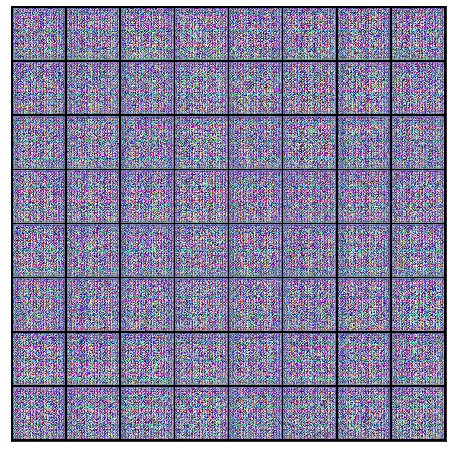

In [48]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)  #fixed latent, to generate 64 images after each epoch
save_samples(0,fixed_latent)

In [49]:
def train(epochs,lr,start_idx=1):
    '''fitting/training models'''
    torch.cuda.empty_cache()
    
    #loss and score containers
    losss_g=[]
    losss_d=[]
    real_scores=[]
    fake_scores=[]
    #optimizers for both the models
    opt_d=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))  #these set of betas are required for generative modelling optimizers
    opt_g=torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))
    
    for epoch in range(epochs):
        for real_img,_ in tqdm(train_dl):
            lossd,real_score,fake_score=train_discrim(real_img,opt_d)  #getting loss and scores from disc
            lossg=train_gen(opt_g)  #getting loss of generator
        #appending scores and losses    
        losss_g.append(lossg)
        losss_d.append(lossd)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, lossg, lossd, real_score, fake_score))
        save_samples(epoch+start_idx,fixed_latent,show=False)
    return losss_g,losss_d,real_scores,fake_scores

In [52]:
lr = 0.003  #learning rate
epochs = 170 #no of training epochs

In [54]:
%%time
history=train(epochs,lr)  #fitting models


Epoch [1/170], loss_g: 5.1008, loss_d: 0.8283, real_score: 0.8678, fake_score: 0.3950
Saving generated-images-0001.png



Epoch [2/170], loss_g: 1.6494, loss_d: 2.3691, real_score: 0.2106, fake_score: 0.1061
Saving generated-images-0002.png



Epoch [3/170], loss_g: 1.3141, loss_d: 1.2517, real_score: 0.6225, fake_score: 0.4899
Saving generated-images-0003.png



Epoch [4/170], loss_g: 2.4950, loss_d: 1.4612, real_score: 0.5952, fake_score: 0.2598
Saving generated-images-0004.png



Epoch [5/170], loss_g: 2.3899, loss_d: 0.4377, real_score: 0.8315, fake_score: 0.1936
Saving generated-images-0005.png



Epoch [6/170], loss_g: 4.7154, loss_d: 0.7216, real_score: 0.9199, fake_score: 0.4406
Saving generated-images-0006.png



Epoch [7/170], loss_g: 4.7360, loss_d: 3.4404, real_score: 0.8896, fake_score: 0.9466
Saving generated-images-0007.png



Epoch [8/170], loss_g: 5.0354, loss_d: 0.0579, real_score: 0.9793, fake_score: 0.0336
Saving generated-images-0008.png



Epoch [9/170], loss_g: 4.5879, loss_d: 0.2498, real_score: 0.8636, fake_score: 0.0728
Saving generated-images-0009.png



Epoch [10/170], loss_g: 1.5574, loss_d: 1.0831, real_score: 0.6015, fake_score: 0.3608
Saving generated-images-0010.png



Epoch [11/170], loss_g: 1.8667, loss_d: 0.8785, real_score: 0.7744, fake_score: 0.3444
Saving generated-images-0011.png



Epoch [12/170], loss_g: 1.2341, loss_d: 1.7816, real_score: 0.2330, fake_score: 0.0517
Saving generated-images-0012.png



Epoch [13/170], loss_g: 1.4367, loss_d: 0.8046, real_score: 0.6299, fake_score: 0.2433
Saving generated-images-0013.png



Epoch [14/170], loss_g: 2.1299, loss_d: 0.8970, real_score: 0.5094, fake_score: 0.0726
Saving generated-images-0014.png



Epoch [15/170], loss_g: 2.8463, loss_d: 1.1000, real_score: 0.7455, fake_score: 0.5110
Saving generated-images-0015.png


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001611F28B948>
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "C:\ProgramData\Miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1174, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'



Epoch [16/170], loss_g: 1.0562, loss_d: 1.1351, real_score: 0.4656, fake_score: 0.1834
Saving generated-images-0016.png



Epoch [17/170], loss_g: 2.5935, loss_d: 0.6446, real_score: 0.6425, fake_score: 0.1050
Saving generated-images-0017.png



Epoch [18/170], loss_g: 2.3464, loss_d: 2.0190, real_score: 0.1817, fake_score: 0.0208
Saving generated-images-0018.png



Epoch [19/170], loss_g: 2.2069, loss_d: 0.4027, real_score: 0.8028, fake_score: 0.1532
Saving generated-images-0019.png



Epoch [20/170], loss_g: 1.6564, loss_d: 0.9735, real_score: 0.6308, fake_score: 0.3484
Saving generated-images-0020.png



Epoch [21/170], loss_g: 2.4862, loss_d: 1.0913, real_score: 0.6295, fake_score: 0.2522
Saving generated-images-0021.png



Epoch [22/170], loss_g: 4.7447, loss_d: 0.7834, real_score: 0.8311, fake_score: 0.4105
Saving generated-images-0022.png



Epoch [23/170], loss_g: 2.3351, loss_d: 0.5256, real_score: 0.7551, fake_score: 0.1775
Saving generated-images-0023.png



Epoch [24/170], loss_g: 3.6641, loss_d: 0.5292, real_score: 0.7855, fake_score: 0.2111
Saving generated-images-0024.png



Epoch [25/170], loss_g: 3.8593, loss_d: 0.9630, real_score: 0.9140, fake_score: 0.5004
Saving generated-images-0025.png



Epoch [26/170], loss_g: 5.0223, loss_d: 1.7392, real_score: 0.6676, fake_score: 0.6732
Saving generated-images-0026.png



Epoch [27/170], loss_g: 2.6566, loss_d: 0.7610, real_score: 0.6454, fake_score: 0.2181
Saving generated-images-0027.png



Epoch [28/170], loss_g: 1.9502, loss_d: 0.4787, real_score: 0.7971, fake_score: 0.1995
Saving generated-images-0028.png



Epoch [29/170], loss_g: 2.5535, loss_d: 0.9197, real_score: 0.8043, fake_score: 0.3962
Saving generated-images-0029.png



Epoch [30/170], loss_g: 3.6159, loss_d: 0.7975, real_score: 0.7293, fake_score: 0.3394
Saving generated-images-0030.png



Epoch [31/170], loss_g: 2.4004, loss_d: 0.3177, real_score: 0.9260, fake_score: 0.1983
Saving generated-images-0031.png



Epoch [32/170], loss_g: 2.5070, loss_d: 0.6644, real_score: 0.7075, fake_score: 0.2310
Saving generated-images-0032.png



Epoch [33/170], loss_g: 5.4565, loss_d: 0.5622, real_score: 0.9550, fake_score: 0.3757
Saving generated-images-0033.png



Epoch [34/170], loss_g: 1.7743, loss_d: 0.6257, real_score: 0.8662, fake_score: 0.3385
Saving generated-images-0034.png



Epoch [35/170], loss_g: 1.8480, loss_d: 1.6341, real_score: 0.6413, fake_score: 0.5243
Saving generated-images-0035.png



Epoch [36/170], loss_g: 2.2010, loss_d: 1.6075, real_score: 0.2699, fake_score: 0.1401
Saving generated-images-0036.png



Epoch [37/170], loss_g: 2.2934, loss_d: 0.5712, real_score: 0.7944, fake_score: 0.2630
Saving generated-images-0037.png



Epoch [38/170], loss_g: 4.2030, loss_d: 1.4210, real_score: 0.6631, fake_score: 0.5825
Saving generated-images-0038.png



Epoch [39/170], loss_g: 0.8389, loss_d: 1.1535, real_score: 0.3843, fake_score: 0.0610
Saving generated-images-0039.png



Epoch [40/170], loss_g: 3.0300, loss_d: 0.7124, real_score: 0.7091, fake_score: 0.2309
Saving generated-images-0040.png



Epoch [41/170], loss_g: 2.3985, loss_d: 0.6555, real_score: 0.7030, fake_score: 0.2105
Saving generated-images-0041.png



Epoch [42/170], loss_g: 2.9629, loss_d: 0.9399, real_score: 0.6393, fake_score: 0.2010
Saving generated-images-0042.png



Epoch [43/170], loss_g: 3.0322, loss_d: 1.0652, real_score: 0.8216, fake_score: 0.5412
Saving generated-images-0043.png



Epoch [44/170], loss_g: 2.6023, loss_d: 0.6781, real_score: 0.6246, fake_score: 0.0947
Saving generated-images-0044.png



Epoch [45/170], loss_g: 0.9473, loss_d: 2.1601, real_score: 0.2354, fake_score: 0.0937
Saving generated-images-0045.png



Epoch [46/170], loss_g: 3.2510, loss_d: 2.9151, real_score: 0.1015, fake_score: 0.0307
Saving generated-images-0046.png



Epoch [47/170], loss_g: 4.1007, loss_d: 0.0902, real_score: 0.9612, fake_score: 0.0462
Saving generated-images-0047.png



Epoch [48/170], loss_g: 4.0171, loss_d: 0.6654, real_score: 0.8977, fake_score: 0.3767
Saving generated-images-0048.png



Epoch [49/170], loss_g: 3.5862, loss_d: 0.5781, real_score: 0.7483, fake_score: 0.1767
Saving generated-images-0049.png



Epoch [50/170], loss_g: 4.5123, loss_d: 0.8860, real_score: 0.9381, fake_score: 0.5123
Saving generated-images-0050.png



Epoch [51/170], loss_g: 4.7897, loss_d: 0.4069, real_score: 0.9311, fake_score: 0.2393
Saving generated-images-0051.png



Epoch [52/170], loss_g: 4.4354, loss_d: 0.7325, real_score: 0.8807, fake_score: 0.3995
Saving generated-images-0052.png



Epoch [53/170], loss_g: 3.5593, loss_d: 3.7719, real_score: 0.0444, fake_score: 0.0066
Saving generated-images-0053.png



Epoch [54/170], loss_g: 4.1905, loss_d: 0.5898, real_score: 0.8174, fake_score: 0.2381
Saving generated-images-0054.png



Epoch [55/170], loss_g: 1.9166, loss_d: 0.6615, real_score: 0.7342, fake_score: 0.1238
Saving generated-images-0055.png



Epoch [56/170], loss_g: 2.6898, loss_d: 0.3512, real_score: 0.8621, fake_score: 0.1534
Saving generated-images-0056.png



Epoch [57/170], loss_g: 3.5708, loss_d: 1.0795, real_score: 0.7557, fake_score: 0.4020
Saving generated-images-0057.png



Epoch [58/170], loss_g: 2.3677, loss_d: 2.3026, real_score: 0.1508, fake_score: 0.0218
Saving generated-images-0058.png



Epoch [59/170], loss_g: 3.4532, loss_d: 0.3870, real_score: 0.8722, fake_score: 0.1808
Saving generated-images-0059.png



Epoch [60/170], loss_g: 4.1099, loss_d: 1.0892, real_score: 0.4700, fake_score: 0.0482
Saving generated-images-0060.png



Epoch [61/170], loss_g: 2.4058, loss_d: 0.2846, real_score: 0.8386, fake_score: 0.0851
Saving generated-images-0061.png



Epoch [62/170], loss_g: 4.7483, loss_d: 0.1976, real_score: 0.8557, fake_score: 0.0256
Saving generated-images-0062.png



Epoch [63/170], loss_g: 5.9622, loss_d: 1.0177, real_score: 0.8355, fake_score: 0.4562
Saving generated-images-0063.png



Epoch [64/170], loss_g: 3.2103, loss_d: 0.5922, real_score: 0.8081, fake_score: 0.2584
Saving generated-images-0064.png



Epoch [65/170], loss_g: 1.7459, loss_d: 0.8289, real_score: 0.6829, fake_score: 0.2813
Saving generated-images-0065.png



Epoch [66/170], loss_g: 1.4887, loss_d: 0.5970, real_score: 0.6983, fake_score: 0.1697
Saving generated-images-0066.png



Epoch [67/170], loss_g: 2.3755, loss_d: 1.2642, real_score: 0.4955, fake_score: 0.2301
Saving generated-images-0067.png



Epoch [68/170], loss_g: 3.7471, loss_d: 0.6491, real_score: 0.7650, fake_score: 0.2590
Saving generated-images-0068.png



Epoch [69/170], loss_g: 2.6569, loss_d: 0.5032, real_score: 0.8674, fake_score: 0.2436
Saving generated-images-0069.png



Epoch [70/170], loss_g: 6.3571, loss_d: 0.4281, real_score: 0.8674, fake_score: 0.1954
Saving generated-images-0070.png



Epoch [71/170], loss_g: 2.8576, loss_d: 0.7300, real_score: 0.6896, fake_score: 0.1845
Saving generated-images-0071.png



Epoch [72/170], loss_g: 2.1710, loss_d: 0.7527, real_score: 0.7048, fake_score: 0.2590
Saving generated-images-0072.png



Epoch [73/170], loss_g: 3.1755, loss_d: 0.7654, real_score: 0.8301, fake_score: 0.3815
Saving generated-images-0073.png



Epoch [74/170], loss_g: 3.5689, loss_d: 0.4249, real_score: 0.8695, fake_score: 0.1780
Saving generated-images-0074.png



Epoch [75/170], loss_g: 3.1829, loss_d: 0.5273, real_score: 0.7015, fake_score: 0.1116
Saving generated-images-0075.png



Epoch [76/170], loss_g: 5.4951, loss_d: 0.3136, real_score: 0.9490, fake_score: 0.1912
Saving generated-images-0076.png



Epoch [77/170], loss_g: 1.6054, loss_d: 1.3707, real_score: 0.3389, fake_score: 0.0398
Saving generated-images-0077.png



Epoch [78/170], loss_g: 4.5913, loss_d: 0.3582, real_score: 0.7579, fake_score: 0.0465
Saving generated-images-0078.png



Epoch [79/170], loss_g: 2.9920, loss_d: 0.9423, real_score: 0.7797, fake_score: 0.4152
Saving generated-images-0079.png



Epoch [80/170], loss_g: 0.3033, loss_d: 3.5474, real_score: 0.0753, fake_score: 0.0022
Saving generated-images-0080.png



Epoch [81/170], loss_g: 5.5679, loss_d: 0.7362, real_score: 0.9254, fake_score: 0.4185
Saving generated-images-0081.png



Epoch [82/170], loss_g: 4.4607, loss_d: 0.2749, real_score: 0.8336, fake_score: 0.0526
Saving generated-images-0082.png



Epoch [83/170], loss_g: 2.7476, loss_d: 0.6605, real_score: 0.7263, fake_score: 0.2256
Saving generated-images-0083.png



Epoch [84/170], loss_g: 2.3389, loss_d: 0.7109, real_score: 0.7490, fake_score: 0.2109
Saving generated-images-0084.png



Epoch [85/170], loss_g: 3.1643, loss_d: 0.3152, real_score: 0.9171, fake_score: 0.1637
Saving generated-images-0085.png



Epoch [86/170], loss_g: 6.2338, loss_d: 1.3863, real_score: 0.9582, fake_score: 0.6452
Saving generated-images-0086.png



Epoch [87/170], loss_g: 3.2748, loss_d: 0.8880, real_score: 0.7154, fake_score: 0.2961
Saving generated-images-0087.png



Epoch [88/170], loss_g: 4.8055, loss_d: 1.5417, real_score: 0.9640, fake_score: 0.6825
Saving generated-images-0088.png



Epoch [89/170], loss_g: 5.0232, loss_d: 1.1873, real_score: 0.9252, fake_score: 0.5683
Saving generated-images-0089.png



Epoch [90/170], loss_g: 3.2905, loss_d: 0.6549, real_score: 0.7382, fake_score: 0.2161
Saving generated-images-0090.png



Epoch [91/170], loss_g: 4.6412, loss_d: 0.6748, real_score: 0.8678, fake_score: 0.3271
Saving generated-images-0091.png



Epoch [92/170], loss_g: 3.3915, loss_d: 0.4518, real_score: 0.7324, fake_score: 0.0664
Saving generated-images-0092.png



Epoch [93/170], loss_g: 2.7428, loss_d: 0.3794, real_score: 0.8534, fake_score: 0.1565
Saving generated-images-0093.png



Epoch [94/170], loss_g: 4.4070, loss_d: 0.3472, real_score: 0.9070, fake_score: 0.1797
Saving generated-images-0094.png



Epoch [95/170], loss_g: 3.8960, loss_d: 0.5736, real_score: 0.7138, fake_score: 0.1290
Saving generated-images-0095.png



Epoch [96/170], loss_g: 2.5043, loss_d: 0.9455, real_score: 0.5605, fake_score: 0.1005
Saving generated-images-0096.png



Epoch [97/170], loss_g: 3.5790, loss_d: 0.1229, real_score: 0.9236, fake_score: 0.0248
Saving generated-images-0097.png



Epoch [98/170], loss_g: 4.1004, loss_d: 0.4540, real_score: 0.9165, fake_score: 0.2602
Saving generated-images-0098.png



Epoch [99/170], loss_g: 1.8296, loss_d: 1.9057, real_score: 0.2990, fake_score: 0.0124
Saving generated-images-0099.png



Epoch [100/170], loss_g: 2.1456, loss_d: 0.3957, real_score: 0.7932, fake_score: 0.1038
Saving generated-images-0100.png



Epoch [101/170], loss_g: 5.2171, loss_d: 1.3075, real_score: 0.9114, fake_score: 0.5766
Saving generated-images-0101.png



Epoch [102/170], loss_g: 1.0271, loss_d: 0.8723, real_score: 0.5445, fake_score: 0.0653
Saving generated-images-0102.png



Epoch [103/170], loss_g: 4.3004, loss_d: 0.3397, real_score: 0.8968, fake_score: 0.1773
Saving generated-images-0103.png



Epoch [104/170], loss_g: 3.8735, loss_d: 0.9578, real_score: 0.9594, fake_score: 0.5002
Saving generated-images-0104.png



Epoch [105/170], loss_g: 4.4401, loss_d: 0.3175, real_score: 0.9626, fake_score: 0.2163
Saving generated-images-0105.png



Epoch [106/170], loss_g: 5.7655, loss_d: 0.4143, real_score: 0.9363, fake_score: 0.2011
Saving generated-images-0106.png



Epoch [107/170], loss_g: 4.0531, loss_d: 0.4126, real_score: 0.8889, fake_score: 0.2005
Saving generated-images-0107.png



Epoch [108/170], loss_g: 2.4700, loss_d: 0.6332, real_score: 0.6735, fake_score: 0.1212
Saving generated-images-0108.png



Epoch [109/170], loss_g: 5.3165, loss_d: 0.5214, real_score: 0.9190, fake_score: 0.2838
Saving generated-images-0109.png



Epoch [110/170], loss_g: 4.8498, loss_d: 0.5767, real_score: 0.9329, fake_score: 0.3229
Saving generated-images-0110.png



Epoch [111/170], loss_g: 1.6122, loss_d: 0.6860, real_score: 0.6371, fake_score: 0.0981
Saving generated-images-0111.png



Epoch [112/170], loss_g: 2.7131, loss_d: 0.6347, real_score: 0.6747, fake_score: 0.0889
Saving generated-images-0112.png



Epoch [113/170], loss_g: 4.6996, loss_d: 0.2424, real_score: 0.9241, fake_score: 0.1248
Saving generated-images-0113.png



Epoch [114/170], loss_g: 6.7511, loss_d: 1.4820, real_score: 0.9532, fake_score: 0.6282
Saving generated-images-0114.png



Epoch [115/170], loss_g: 4.8292, loss_d: 0.5543, real_score: 0.7114, fake_score: 0.0439
Saving generated-images-0115.png



Epoch [116/170], loss_g: 3.6524, loss_d: 0.4001, real_score: 0.7737, fake_score: 0.0394
Saving generated-images-0116.png



Epoch [117/170], loss_g: 3.9294, loss_d: 0.5541, real_score: 0.6560, fake_score: 0.0165
Saving generated-images-0117.png



Epoch [118/170], loss_g: 3.2459, loss_d: 0.2338, real_score: 0.8597, fake_score: 0.0509
Saving generated-images-0118.png



Epoch [119/170], loss_g: 4.2322, loss_d: 0.4765, real_score: 0.9770, fake_score: 0.2844
Saving generated-images-0119.png



Epoch [120/170], loss_g: 2.2957, loss_d: 0.4341, real_score: 0.7638, fake_score: 0.0623
Saving generated-images-0120.png



Epoch [121/170], loss_g: 4.4077, loss_d: 0.1910, real_score: 0.8748, fake_score: 0.0232
Saving generated-images-0121.png



Epoch [122/170], loss_g: 3.9922, loss_d: 0.4306, real_score: 0.8356, fake_score: 0.1465
Saving generated-images-0122.png



Epoch [123/170], loss_g: 5.4457, loss_d: 0.5951, real_score: 0.8993, fake_score: 0.2360
Saving generated-images-0123.png



Epoch [124/170], loss_g: 6.4720, loss_d: 0.4412, real_score: 0.7186, fake_score: 0.0033
Saving generated-images-0124.png



Epoch [125/170], loss_g: 8.7344, loss_d: 0.0216, real_score: 0.9820, fake_score: 0.0026
Saving generated-images-0125.png



Epoch [126/170], loss_g: 2.8678, loss_d: 0.3494, real_score: 0.8033, fake_score: 0.0518
Saving generated-images-0126.png



Epoch [127/170], loss_g: 3.0871, loss_d: 0.4416, real_score: 0.7879, fake_score: 0.1085
Saving generated-images-0127.png



Epoch [128/170], loss_g: 5.1794, loss_d: 0.3424, real_score: 0.9151, fake_score: 0.1774
Saving generated-images-0128.png



Epoch [129/170], loss_g: 14.2976, loss_d: 4.6025, real_score: 1.0000, fake_score: 0.9320
Saving generated-images-0129.png



Epoch [130/170], loss_g: 5.9440, loss_d: 0.4066, real_score: 0.9263, fake_score: 0.2173
Saving generated-images-0130.png



Epoch [131/170], loss_g: 4.4942, loss_d: 0.1343, real_score: 0.9790, fake_score: 0.0889
Saving generated-images-0131.png



Epoch [132/170], loss_g: 4.8956, loss_d: 0.2418, real_score: 0.9968, fake_score: 0.1797
Saving generated-images-0132.png



Epoch [133/170], loss_g: 3.5848, loss_d: 0.6493, real_score: 0.8511, fake_score: 0.2836
Saving generated-images-0133.png



Epoch [134/170], loss_g: 5.0342, loss_d: 0.1989, real_score: 0.9384, fake_score: 0.0973
Saving generated-images-0134.png



Epoch [135/170], loss_g: 4.4168, loss_d: 0.2094, real_score: 0.9411, fake_score: 0.0795
Saving generated-images-0135.png



Epoch [136/170], loss_g: 4.7158, loss_d: 0.1131, real_score: 0.9534, fake_score: 0.0511
Saving generated-images-0136.png



Epoch [137/170], loss_g: 4.0176, loss_d: 0.2242, real_score: 0.8760, fake_score: 0.0191
Saving generated-images-0137.png



Epoch [138/170], loss_g: 5.9659, loss_d: 0.1154, real_score: 0.9652, fake_score: 0.0651
Saving generated-images-0138.png



Epoch [139/170], loss_g: 5.2996, loss_d: 0.2947, real_score: 0.9677, fake_score: 0.1693
Saving generated-images-0139.png



Epoch [140/170], loss_g: 7.1728, loss_d: 0.0621, real_score: 0.9904, fake_score: 0.0397
Saving generated-images-0140.png



Epoch [141/170], loss_g: 4.6983, loss_d: 0.3175, real_score: 0.8911, fake_score: 0.1377
Saving generated-images-0141.png



Epoch [142/170], loss_g: 3.8398, loss_d: 0.1552, real_score: 0.9768, fake_score: 0.1013
Saving generated-images-0142.png



Epoch [143/170], loss_g: 4.6127, loss_d: 0.2271, real_score: 0.9284, fake_score: 0.1084
Saving generated-images-0143.png



Epoch [144/170], loss_g: 6.1717, loss_d: 0.1004, real_score: 0.9475, fake_score: 0.0377
Saving generated-images-0144.png



Epoch [145/170], loss_g: 4.2453, loss_d: 0.2110, real_score: 0.8590, fake_score: 0.0154
Saving generated-images-0145.png



Epoch [146/170], loss_g: 4.3443, loss_d: 0.2320, real_score: 0.8354, fake_score: 0.0209
Saving generated-images-0146.png



Epoch [147/170], loss_g: 3.3262, loss_d: 0.2262, real_score: 0.9655, fake_score: 0.1154
Saving generated-images-0147.png



Epoch [148/170], loss_g: 7.1955, loss_d: 0.1986, real_score: 0.9995, fake_score: 0.1264
Saving generated-images-0148.png



Epoch [149/170], loss_g: 3.6500, loss_d: 0.3984, real_score: 0.7803, fake_score: 0.0382
Saving generated-images-0149.png



Epoch [150/170], loss_g: 3.1603, loss_d: 0.5103, real_score: 0.8110, fake_score: 0.1370
Saving generated-images-0150.png



Epoch [151/170], loss_g: 5.6655, loss_d: 0.1238, real_score: 0.9957, fake_score: 0.0977
Saving generated-images-0151.png



Epoch [152/170], loss_g: 14.9464, loss_d: 1.7829, real_score: 0.9997, fake_score: 0.6663
Saving generated-images-0152.png



Epoch [153/170], loss_g: 4.8220, loss_d: 0.1369, real_score: 0.9299, fake_score: 0.0483
Saving generated-images-0153.png



Epoch [154/170], loss_g: 6.8067, loss_d: 0.0938, real_score: 0.9320, fake_score: 0.0117
Saving generated-images-0154.png



Epoch [155/170], loss_g: 7.0398, loss_d: 0.1878, real_score: 0.9694, fake_score: 0.1103
Saving generated-images-0155.png



Epoch [156/170], loss_g: 5.2385, loss_d: 0.7896, real_score: 0.5839, fake_score: 0.0047
Saving generated-images-0156.png



Epoch [157/170], loss_g: 7.6210, loss_d: 0.0545, real_score: 0.9889, fake_score: 0.0349
Saving generated-images-0157.png



Epoch [158/170], loss_g: 4.6719, loss_d: 0.0959, real_score: 0.9482, fake_score: 0.0317
Saving generated-images-0158.png



Epoch [159/170], loss_g: 2.7657, loss_d: 0.4151, real_score: 0.7583, fake_score: 0.0168
Saving generated-images-0159.png



Epoch [160/170], loss_g: 6.2696, loss_d: 0.2420, real_score: 0.9729, fake_score: 0.1600
Saving generated-images-0160.png



Epoch [161/170], loss_g: 5.2439, loss_d: 0.1408, real_score: 0.9974, fake_score: 0.0926
Saving generated-images-0161.png



Epoch [162/170], loss_g: 5.6160, loss_d: 0.2013, real_score: 0.8589, fake_score: 0.0142
Saving generated-images-0162.png



Epoch [163/170], loss_g: 6.1395, loss_d: 0.1688, real_score: 0.9999, fake_score: 0.1247
Saving generated-images-0163.png



Epoch [164/170], loss_g: 5.0698, loss_d: 0.0638, real_score: 0.9810, fake_score: 0.0385
Saving generated-images-0164.png



Epoch [165/170], loss_g: 7.1109, loss_d: 0.2384, real_score: 0.9434, fake_score: 0.1090
Saving generated-images-0165.png



Epoch [166/170], loss_g: 4.9264, loss_d: 0.2678, real_score: 0.9309, fake_score: 0.1076
Saving generated-images-0166.png



Epoch [167/170], loss_g: 11.6663, loss_d: 0.0461, real_score: 0.9653, fake_score: 0.0024
Saving generated-images-0167.png



Epoch [168/170], loss_g: 5.2027, loss_d: 0.1956, real_score: 0.9237, fake_score: 0.0723
Saving generated-images-0168.png



Epoch [169/170], loss_g: 6.9099, loss_d: 0.1272, real_score: 0.9567, fake_score: 0.0487
Saving generated-images-0169.png



Epoch [170/170], loss_g: 7.1379, loss_d: 0.0276, real_score: 0.9990, fake_score: 0.0244
Saving generated-images-0170.png
Wall time: 4h 48min 49s


since the gpu we were using was'nt good enough (mx150) the total time our model took for training for 170 epochs is 4h 48min 49s

## Saving Model and Checking Results

In [57]:
torch.save(generator.state_dict(), 'models/artgenerator_170epoch.pth')  #SAVING GENERATOR MODEL

In [58]:
torch.save(discriminator.state_dict(), 'models/artdiscriminator_170epoch.pth')  #SAVING DISC MODEL

In [59]:
#generating training video
import cv2
import os

vid_fname = 'artgans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [64]:
#Getting sample from random vector
latent_vector=torch.randn(1,latent_size,1,1,device=device)
generated=generator(latent_vector)

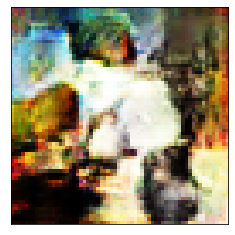

In [65]:
#Lets check what is the type of art our model is generating
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(torch.squeeze(denorm(generated.cpu().detach(),*stats)).permute(1,2,0))

In [67]:
model=to_device(generator,device)   #loading our trained model for inference
model.load_state_dict(torch.load('models/artgenerator_170epoch.pth'))

<All keys matched successfully>

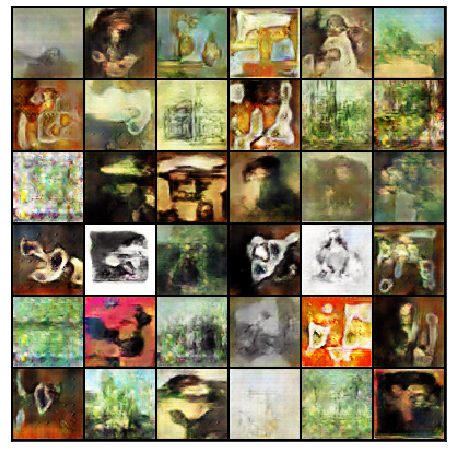

In [74]:
latent_vector=torch.randn(36,latent_size,1,1,device=device)  #creating a latent vector for 36 images
gen=model(latent_vector)        #generating art from latent vector
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(denorm(gen.cpu().detach(),*stats),nrow=6).permute(1,2,0))

We've covered a journey so far this is the output of out model generating art out of some random vector is'nt it amazing? 